In [1]:
# Célula 1: Instalação da biblioteca gdown
# Esta biblioteca é especialista em baixar arquivos do Google Drive.
# O '!' permite executar comandos do terminal diretamente no notebook.

%pip install gdown -q
print("Biblioteca gdown pronta para uso.")

Note: you may need to restart the kernel to use updated packages.
Biblioteca gdown pronta para uso.


In [2]:
# Célula 2: Download dos arquivos do Google Drive

import gdown
import os

# Dicionário com os IDs dos arquivos e os nomes que eles terão localmente
files_to_download = {
    'applicants.json': '1qjXzQiAGrdZAqSSPAn1oYBWsxmNd_4KH',
    'prospects.json':  '1MlRZkZnBVD7jKwigKhSWiFkoNnt8-QY7',
    'vagas.json':      '1bkj1C4GQvG824A4rb9LBy8Q6TiRyy08L'
}

print("Iniciando o download dos arquivos...")

for filename, file_id in files_to_download.items():
    # Constrói a URL de download direta
    url = f'https://drive.google.com/uc?id={file_id}'
    
    # Baixa o arquivo. O 'quiet=True' evita muita poluição visual na saída.
    gdown.download(url, filename, quiet=True)
    
    # Verifica se o arquivo foi baixado com sucesso
    if os.path.exists(filename):
        print(f"✅ Arquivo '{filename}' baixado com sucesso!")
    else:
        print(f"❌ Falha no download do arquivo '{filename}'. Verifique o link e as permissões.")

print("\nDownload concluído!")

Iniciando o download dos arquivos...
✅ Arquivo 'applicants.json' baixado com sucesso!
✅ Arquivo 'prospects.json' baixado com sucesso!
✅ Arquivo 'vagas.json' baixado com sucesso!

Download concluído!


In [3]:
# Célula 3: Importando bibliotecas e definindo funções de processamento

import pandas as pd
import json
import numpy as np

def flatten_json_to_dataframe(filepath, processor_func):
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    all_records = [record for key, value in data.items() for record in processor_func(key, value)]
    return pd.DataFrame(all_records)

def process_prospects(vaga_id, vaga_data):
    return [{**p, 'vaga_id': vaga_id} for p in vaga_data.get('prospects', [])]

def process_vagas(vaga_id, vaga_data):
    return [{**vaga_data.get('informacoes_basicas', {}), **vaga_data.get('perfil_vaga', {}), 'vaga_id': vaga_id}]

def process_applicants(applicant_id, applicant_data):
    return [{
        **applicant_data.get('infos_basicas', {}),
        **applicant_data.get('informacoes_pessoais', {}),
        **applicant_data.get('informacoes_profissionais', {}),
        **applicant_data.get('formacao_e_idiomas', {}),
        'cv_pt': applicant_data.get('cv_pt', ''),
        'applicant_id': applicant_id
    }]

print("Funções de processamento prontas.")

Funções de processamento prontas.


In [4]:
# Célula 4: Carregando, tratando e unindo os dados

# Carregar
df_prospects = flatten_json_to_dataframe('prospects.json', process_prospects)
df_vagas = flatten_json_to_dataframe('vagas.json', process_vagas)
df_applicants = flatten_json_to_dataframe('applicants.json', process_applicants)

# Renomear colunas conflitantes
df_prospects.rename(columns={'codigo': 'applicant_id'}, inplace=True)
df_vagas.rename(columns={'nivel profissional': 'vaga_nivel_profissional', 'nivel_academico': 'vaga_nivel_academico'}, inplace=True)
df_applicants.rename(columns={'nivel_academico': 'applicant_nivel_academico', 'nivel_profissional': 'applicant_nivel_profissional', 'nome': 'applicant_nome'}, inplace=True)

# Unir os DataFrames
df_merged = pd.merge(df_prospects, df_vagas, on='vaga_id', how='left')
df_merged['applicant_id'] = df_merged['applicant_id'].astype(str)
df_applicants['applicant_id'] = df_applicants['applicant_id'].astype(str)
df_final = pd.merge(df_merged, df_applicants, on='applicant_id', how='left')

# Limpeza final e Engenharia de Features
def clean_remuneracao(value):
    if isinstance(value, str):
        try:
            return float(value.replace('.', '').replace(',', '.'))
        except (ValueError, AttributeError):
            return np.nan
    return value

df_final['remuneracao_cleaned'] = df_final['remuneracao'].apply(clean_remuneracao)
df_final['data_candidatura'] = pd.to_datetime(df_final['data_candidatura'], format='%d-%m-%Y', errors='coerce')
df_final['ultima_atualizacao'] = pd.to_datetime(df_final['ultima_atualizacao'], format='%d-%m-%Y', errors='coerce')
df_final['tempo_processo_dias'] = (df_final['ultima_atualizacao'] - df_final['data_candidatura']).dt.days

# Preenchendo valores nulos
for col in ['cv_pt', 'principais_atividades', 'vaga_nivel_profissional', 'applicant_nivel_academico']:
    df_final[col] = df_final[col].fillna('Não informado')
df_final['remuneracao_cleaned'].fillna(df_final['remuneracao_cleaned'].median(), inplace=True)
df_final['tempo_processo_dias'].fillna(df_final['tempo_processo_dias'].median(), inplace=True)

# Salvando o resultado para uso futuro
df_final.to_csv('dados_consolidados_limpos.csv', index=False)

print("Dados tratados, unidos e salvos em 'dados_consolidados_limpos.csv'.")
df_final.info()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_11348\2240156870.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['remuneracao_cleaned'].fillna(df_final['remuneracao_cleaned'].median(), inplace=True)
C:\Users\Rafael\AppData\Local\Temp\ipykernel_11348\2240156870.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

Dados tratados, unidos e salvos em 'dados_consolidados_limpos.csv'.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53759 entries, 0 to 53758
Data columns (total 94 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   nome_x                                   53759 non-null  object        
 1   applicant_id                             53759 non-null  object        
 2   situacao_candidado                       53759 non-null  object        
 3   data_candidatura                         53759 non-null  datetime64[ns]
 4   ultima_atualizacao                       49846 non-null  datetime64[ns]
 5   comentario                               53759 non-null  object        
 6   recrutador                               53759 non-null  object        
 7   vaga_id                                  53759 non-null  object        
 8   data_requicisao                          53735 n

C:\Users\Rafael\AppData\Local\Temp\ipykernel_11348\3829806260.py:12: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados_consolidados_limpos.csv')
C:\Users\Rafael\AppData\Local\Temp\ipykernel_11348\3829806260.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.values, y=status_counts.index, palette='viridis', orient='h')


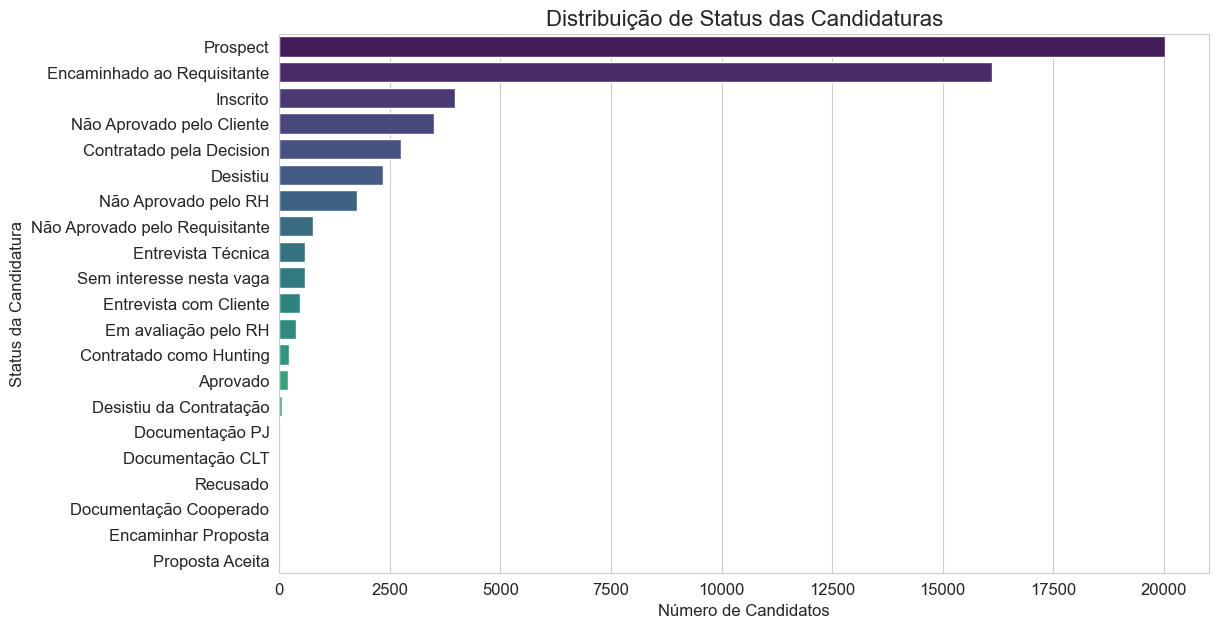

In [5]:
# Célula 5: Configuração e Análise do Status das Candidaturas

import matplotlib.pyplot as plt
import seaborn as sns

# Configurações para os gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# Carregando o arquivo que geramos
df = pd.read_csv('dados_consolidados_limpos.csv')

# Gráfico 1: Distribuição de Status das Candidaturas
plt.figure()
status_counts = df['situacao_candidado'].value_counts()
sns.barplot(x=status_counts.values, y=status_counts.index, palette='viridis', orient='h')
plt.title('Distribuição de Status das Candidaturas', fontsize=16)
plt.xlabel('Número de Candidatos')
plt.ylabel('Status da Candidatura')
plt.show()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_11348\184014317.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nivel_counts.index, y=nivel_counts.values, palette='crest')


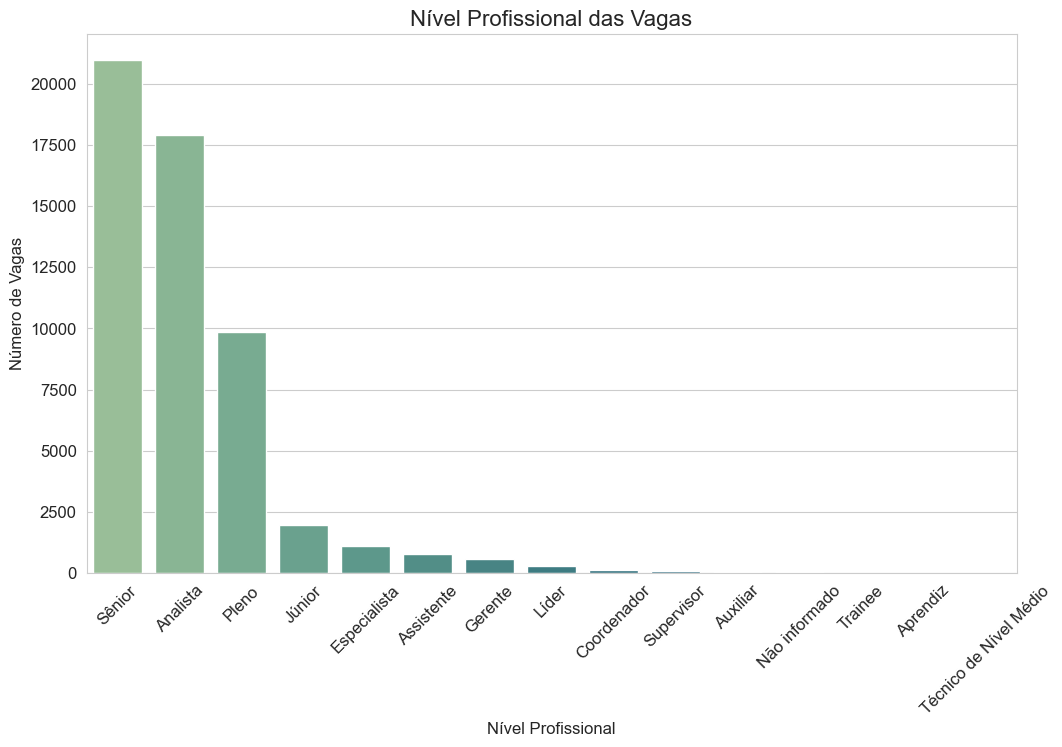

In [6]:
# Célula 6: Análise do Nível Profissional das Vagas

plt.figure()
nivel_counts = df['vaga_nivel_profissional'].value_counts()
sns.barplot(x=nivel_counts.index, y=nivel_counts.values, palette='crest')
plt.title('Nível Profissional das Vagas', fontsize=16)
plt.xlabel('Nível Profissional')
plt.ylabel('Número de Vagas')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Célula 7: Preparação para o Treinamento do Modelo (VERSÃO CORRIGIDA)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Definindo a variável alvo (target)
df['target'] = (df['situacao_candidado'] == 'Encaminhado ao Requisitante').astype(int)

# Selecionando as colunas que o modelo usará para aprender
numerical_features = ['remuneracao_cleaned', 'tempo_processo_dias']
categorical_features = ['vaga_nivel_profissional', 'applicant_nivel_academico', 'recrutador']
text_feature = 'cv_pt'

features = numerical_features + categorical_features + [text_feature]
X = df[features].copy() # Usamos .copy() para evitar avisos
y = df['target']

# --- INÍCIO DA CORREÇÃO ---
# Garantindo que não há valores nulos nas colunas de features
X[categorical_features] = X[categorical_features].fillna('Não informado')
X[text_feature] = X[text_feature].fillna('') # Garante que a coluna de CV não tenha nulos
# --- FIM DA CORREGEÇÃO ---

# Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Dados preparados para o treinamento (com limpeza final).")

Dados preparados para o treinamento (com limpeza final).


In [12]:
# Célula 8: Construção do Pipeline de Pré-processamento e Modelagem

# Criando os transformadores para cada tipo de coluna
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
# Otimizamos os parâmetros para um treinamento mais rápido
text_transformer = TfidfVectorizer(max_features=200, min_df=2, stop_words='english')

# Combinando os transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_feature)
    ],
    remainder='passthrough'
)

# Criando o pipeline final que une o pré-processamento ao modelo
# Otimizamos o modelo para ser mais rápido, usando n_jobs=-1 para usar todos os processadores
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=50, n_jobs=-1))
])

print("Pipeline de Machine Learning construído com sucesso!")

Pipeline de Machine Learning construído com sucesso!


Iniciando o treinamento do modelo...
Treinamento concluído!

Acurácia do Modelo: 72.22%

Relatório de Classificação:
                 precision    recall  f1-score   support

Não Encaminhado       0.79      0.83      0.81      9409
    Encaminhado       0.54      0.47      0.50      4031

       accuracy                           0.72     13440
      macro avg       0.66      0.65      0.66     13440
   weighted avg       0.71      0.72      0.72     13440

Matriz de Confusão:


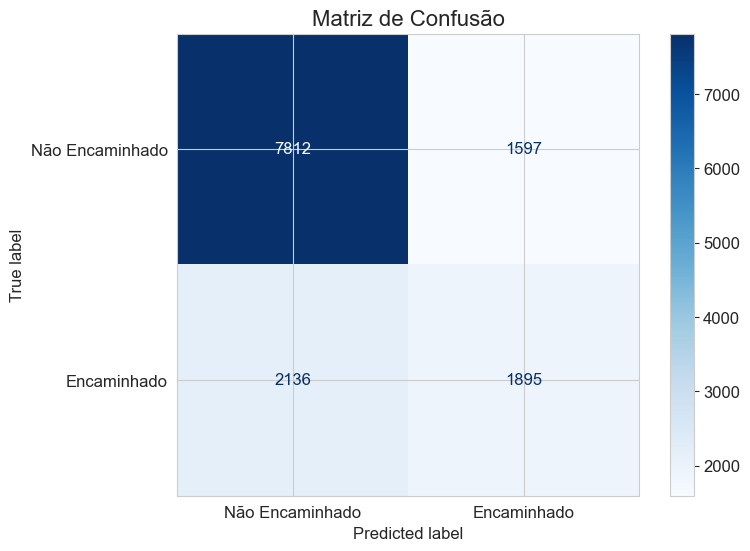

In [13]:
# Célula 9: Treinamento e Avaliação do Modelo

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Treinando o modelo
print("Iniciando o treinamento do modelo...")
model_pipeline.fit(X_train, y_train)
print("Treinamento concluído!")

# Fazendo previsões
y_pred = model_pipeline.predict(X_test)

# Avaliando a performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do Modelo: {accuracy:.2%}\n")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Não Encaminhado', 'Encaminhado']))

# Visualizando a Matriz de Confusão
print("Matriz de Confusão:")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', display_labels=['Não Encaminhado', 'Encaminhado'])
plt.title('Matriz de Confusão', fontsize=16)
plt.show()

In [14]:
# Célula 10: Salvando o Modelo Treinado para o Deploy

import joblib

# Nome do arquivo que irá conter nosso modelo treinado
model_filename = 'recruitment_model.joblib'

# Salvando o objeto model_pipeline no arquivo
joblib.dump(model_pipeline, model_filename)

print(f"Modelo salvo com sucesso no arquivo: '{model_filename}'")

Modelo salvo com sucesso no arquivo: 'recruitment_model.joblib'
